In [32]:
import tensorflow as tf
import numpy as np

# 加载CIFAR-10数据集
(X, Y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
def preprocess(x, y):
    x = x.reshape(-1, 3072).astype(np.float32) / 255.0 
    y = np.eye(10)[y.flatten().astype(int)]              
    return x, y
x_train, y_train = preprocess(X[:45000], Y[:45000])  
x_val, y_val = preprocess(X[45000:], Y[45000:])      
x_test, y_test = preprocess(x_test, y_test)                    

In [54]:
class ThreeLayerNet:
    def __init__(self, input_size, hidden_size, output_size, activation='relu', reg=0):
        self.params = {
            "W1": np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size),
            "b1": np.zeros(hidden_size),
            "W2": np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size),
            "b2": np.zeros(output_size)
        }
        self.activation = activation.lower()
        self.reg = reg
    
    def _activation_fn(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
    
    def _activation_derivative(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig)
        elif self.activation == 'tanh':
            return 1 - np.tanh(x)**2
    
    def forward(self, X):
        self.z1 = X.dot(self.params["W1"]) + self.params["b1"]
        self.a1 = self._activation_fn(self.z1)
        self.scores = self.a1.dot(self.params["W2"]) + self.params["b2"]
        return self.scores
    
    def backward(self, X, y, scores, lr):
        m = X.shape[0]
        grad = {}
        
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        dscores = (probs - y) / m
        
        grad["W2"] = self.a1.T.dot(dscores) + 2 * self.reg * self.params["W2"]
        grad["b2"] = np.sum(dscores, axis=0)
        
        da1 = dscores.dot(self.params["W2"].T)
        dz1 = da1 * self._activation_derivative(self.z1)
        grad["W1"] = X.T.dot(dz1) + 2 * self.reg * self.params["W1"]
        grad["b1"] = np.sum(dz1, axis=0)
        
        # 参数更新（可选梯度裁剪）
        for param in self.params:
            self.params[param] -= lr * grad[param]

    def load_from_np(self, path):
        ckpt = np.load(path)
        self.params = {key: para[key] for key in ckpt.files}

In [63]:
def train(model, X_train, y_train, X_val, y_val, 
          lr=1e-3, epochs=100, batch_size=64, lr_decay=0.95):
    # 记录各项指标
    history = {
        'train_loss': [],       # 每个epoch的训练loss
        'train_ce_loss': [],    # 每个epoch的交叉熵loss 
        'val_loss': [],         # 每个epoch的验证loss
        'val_acc': [],          # 每个epoch的验证准确率
        'weights': []           # 每个epoch的权重
    }
    
    best_acc = 0
    best_params = None
    
    for epoch in tqdm(range(epochs), position=0):
        # 学习率衰减
        lr *= lr_decay
        permutation = np.random.permutation(X_train.shape[0])
        epoch_ce_loss = []
        epoch_total_loss = []
        
        for i in range(0, X_train.shape[0], batch_size):
            batch_idx = permutation[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            current_batch_size = X_batch.shape[0]
            
            # 前向传播
            scores = model.forward(X_batch)
            exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            ce_loss = -np.log(probs[range(current_batch_size), np.argmax(y_batch, axis=1)]).mean()
            reg_loss = 0.5 * model.reg * (np.sum(model.params["W1"]**2) + np.sum(model.params["W2"]**2))
            total_loss = ce_loss + reg_loss
            
            epoch_ce_loss.append(ce_loss)
            epoch_total_loss.append(total_loss)
            
            # 反向传播
            model.backward(X_batch, y_batch, scores, lr)
        
        val_scores = model.forward(X_val)
        val_preds = np.argmax(val_scores, axis=1)
        acc = np.mean(val_preds == np.argmax(y_val, axis=1))
        
        val_exp_scores = np.exp(val_scores - np.max(val_scores, axis=1, keepdims=True))
        val_probs = val_exp_scores / np.sum(val_exp_scores, axis=1, keepdims=True)
        val_ce_loss = -np.log(val_probs[range(len(y_val)), np.argmax(y_val, axis=1)]).mean()
        val_reg_loss = 0.5 * model.reg * (np.sum(model.params["W1"]**2) + np.sum(model.params["W2"]**2))
        val_total_loss = val_ce_loss + val_reg_loss
        
        history['train_ce_loss'].append(np.mean(epoch_ce_loss))
        history['train_loss'].append(np.mean(epoch_total_loss))
        history['val_loss'].append(val_total_loss)
        history['val_acc'].append(acc)
        history['weights'].append({
            'W1': model.params["W1"].copy(),
            'W2': model.params["W2"].copy()
        })
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch}: Train CE Loss={history["train_ce_loss"][-1]:.4f} || '
                  f'Train Loss={history["train_loss"][-1]:.4f}  || '
                  f'Val Loss={history["val_loss"][-1]:.4f}  || '
                  f'Val Acc={history["val_acc"][-1]:.4f}')
        
        if acc > best_acc:
            best_acc = acc
            best_params = model.params.copy()
      
    return best_params, history

In [65]:
hidden_sizes = [256, 512]
learning_rates = [1e-3, 5e-4]
regularizations = [1e-4, 1e-3]

best_acc = 0
best_params = None
history_list = []
best_history = []
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for reg in regularizations:
            print(f'Now lr : {lr} || hidden_size : {hidden_size} || regular : {reg}')
            model = ThreeLayerNet(3072, hidden_size, 10, activation='relu', reg=reg)
            params, history = train(model, x_train, y_train, x_val, y_val,
                                               lr=lr, epochs=50)
            val_acc = history['val_acc']
            if max(val_acc) > best_acc:
                best_acc = max(val_acc)
                best_params = params
                best_history = history
np.savez('/kaggle/working/best_model.npz', **best_params)

Now lr : 0.001 || hidden_size : 256 || regular : 0.0001


  2%|▏         | 1/50 [00:06<05:03,  6.19s/it]

Epoch 0: Train CE Loss=2.1589 || Train Loss=2.1855  || Val Loss=2.0901  || Val Acc=0.2612


 22%|██▏       | 11/50 [01:06<03:52,  5.97s/it]

Epoch 10: Train CE Loss=1.8067 || Train Loss=1.8334  || Val Loss=1.8486  || Val Acc=0.3708


 42%|████▏     | 21/50 [02:05<02:54,  6.03s/it]

Epoch 20: Train CE Loss=1.7551 || Train Loss=1.7818  || Val Loss=1.8028  || Val Acc=0.3932


 62%|██████▏   | 31/50 [03:04<01:52,  5.91s/it]

Epoch 30: Train CE Loss=1.7306 || Train Loss=1.7573  || Val Loss=1.7819  || Val Acc=0.3986


 82%|████████▏ | 41/50 [04:04<00:53,  5.92s/it]

Epoch 40: Train CE Loss=1.7164 || Train Loss=1.7431  || Val Loss=1.7702  || Val Acc=0.4012


100%|██████████| 50/50 [04:58<00:00,  5.97s/it]


Epoch 49: Train CE Loss=1.7096 || Train Loss=1.7363  || Val Loss=1.7644  || Val Acc=0.4044
Now lr : 0.001 || hidden_size : 256 || regular : 0.001


  2%|▏         | 1/50 [00:06<04:59,  6.11s/it]

Epoch 0: Train CE Loss=2.1386 || Train Loss=2.4040  || Val Loss=2.3083  || Val Acc=0.2722


 22%|██▏       | 11/50 [01:07<04:01,  6.19s/it]

Epoch 10: Train CE Loss=1.7980 || Train Loss=2.0593  || Val Loss=2.0752  || Val Acc=0.3744


 42%|████▏     | 21/50 [02:10<03:01,  6.27s/it]

Epoch 20: Train CE Loss=1.7503 || Train Loss=2.0091  || Val Loss=2.0320  || Val Acc=0.3824


 62%|██████▏   | 31/50 [03:12<01:57,  6.20s/it]

Epoch 30: Train CE Loss=1.7274 || Train Loss=1.9846  || Val Loss=2.0121  || Val Acc=0.3946


 82%|████████▏ | 41/50 [04:15<00:55,  6.22s/it]

Epoch 40: Train CE Loss=1.7156 || Train Loss=1.9719  || Val Loss=2.0003  || Val Acc=0.3982


100%|██████████| 50/50 [05:11<00:00,  6.23s/it]


Epoch 49: Train CE Loss=1.7097 || Train Loss=1.9656  || Val Loss=1.9942  || Val Acc=0.4002
Now lr : 0.0005 || hidden_size : 256 || regular : 0.0001


  2%|▏         | 1/50 [00:06<05:30,  6.75s/it]

Epoch 0: Train CE Loss=2.2295 || Train Loss=2.2561  || Val Loss=2.1482  || Val Acc=0.2382


 22%|██▏       | 11/50 [01:08<04:02,  6.21s/it]

Epoch 10: Train CE Loss=1.8596 || Train Loss=1.8862  || Val Loss=1.8963  || Val Acc=0.3508


 42%|████▏     | 21/50 [02:08<02:59,  6.18s/it]

Epoch 20: Train CE Loss=1.8115 || Train Loss=1.8381  || Val Loss=1.8531  || Val Acc=0.3654


 62%|██████▏   | 31/50 [03:08<01:53,  5.99s/it]

Epoch 30: Train CE Loss=1.7896 || Train Loss=1.8162  || Val Loss=1.8341  || Val Acc=0.3732


 82%|████████▏ | 41/50 [04:09<00:54,  6.02s/it]

Epoch 40: Train CE Loss=1.7787 || Train Loss=1.8054  || Val Loss=1.8253  || Val Acc=0.3770


100%|██████████| 50/50 [05:04<00:00,  6.09s/it]


Epoch 49: Train CE Loss=1.7729 || Train Loss=1.7996  || Val Loss=1.8203  || Val Acc=0.3788
Now lr : 0.0005 || hidden_size : 256 || regular : 0.001


  2%|▏         | 1/50 [00:06<04:58,  6.10s/it]

Epoch 0: Train CE Loss=2.1936 || Train Loss=2.4600  || Val Loss=2.3790  || Val Acc=0.2436


 22%|██▏       | 11/50 [01:07<03:58,  6.10s/it]

Epoch 10: Train CE Loss=1.8762 || Train Loss=2.1405  || Val Loss=2.1489  || Val Acc=0.3536


 42%|████▏     | 21/50 [02:09<02:58,  6.16s/it]

Epoch 20: Train CE Loss=1.8270 || Train Loss=2.0900  || Val Loss=2.1055  || Val Acc=0.3686


 62%|██████▏   | 31/50 [03:10<01:57,  6.17s/it]

Epoch 30: Train CE Loss=1.8062 || Train Loss=2.0684  || Val Loss=2.0855  || Val Acc=0.3748


 82%|████████▏ | 41/50 [04:12<00:56,  6.23s/it]

Epoch 40: Train CE Loss=1.7945 || Train Loss=2.0563  || Val Loss=2.0755  || Val Acc=0.3802


100%|██████████| 50/50 [05:08<00:00,  6.16s/it]


Epoch 49: Train CE Loss=1.7891 || Train Loss=2.0507  || Val Loss=2.0701  || Val Acc=0.3802
Now lr : 0.001 || hidden_size : 512 || regular : 0.0001


  2%|▏         | 1/50 [00:13<11:09, 13.65s/it]

Epoch 0: Train CE Loss=2.1421 || Train Loss=2.1943  || Val Loss=2.0979  || Val Acc=0.2738


 22%|██▏       | 11/50 [02:28<08:44, 13.44s/it]

Epoch 10: Train CE Loss=1.7898 || Train Loss=1.8420  || Val Loss=1.8632  || Val Acc=0.3730


 42%|████▏     | 21/50 [04:44<06:39, 13.76s/it]

Epoch 20: Train CE Loss=1.7402 || Train Loss=1.7924  || Val Loss=1.8187  || Val Acc=0.3906


 62%|██████▏   | 31/50 [07:00<04:15, 13.42s/it]

Epoch 30: Train CE Loss=1.7152 || Train Loss=1.7674  || Val Loss=1.7972  || Val Acc=0.4006


 82%|████████▏ | 41/50 [09:15<02:01, 13.53s/it]

Epoch 40: Train CE Loss=1.7022 || Train Loss=1.7545  || Val Loss=1.7865  || Val Acc=0.4036


100%|██████████| 50/50 [11:16<00:00, 13.53s/it]


Epoch 49: Train CE Loss=1.6955 || Train Loss=1.7477  || Val Loss=1.7803  || Val Acc=0.4068
Now lr : 0.001 || hidden_size : 512 || regular : 0.001


  2%|▏         | 1/50 [00:13<11:03, 13.54s/it]

Epoch 0: Train CE Loss=2.1486 || Train Loss=2.6691  || Val Loss=2.5645  || Val Acc=0.2924


 22%|██▏       | 11/50 [02:24<08:32, 13.14s/it]

Epoch 10: Train CE Loss=1.7969 || Train Loss=2.3079  || Val Loss=2.3264  || Val Acc=0.3626


 42%|████▏     | 21/50 [04:36<06:22, 13.20s/it]

Epoch 20: Train CE Loss=1.7474 || Train Loss=2.2528  || Val Loss=2.2758  || Val Acc=0.3826


 62%|██████▏   | 31/50 [06:47<04:10, 13.20s/it]

Epoch 30: Train CE Loss=1.7238 || Train Loss=2.2259  || Val Loss=2.2517  || Val Acc=0.3934


 82%|████████▏ | 41/50 [08:58<01:58, 13.14s/it]

Epoch 40: Train CE Loss=1.7114 || Train Loss=2.2115  || Val Loss=2.2392  || Val Acc=0.3964


100%|██████████| 50/50 [10:57<00:00, 13.14s/it]


Epoch 49: Train CE Loss=1.7050 || Train Loss=2.2040  || Val Loss=2.2325  || Val Acc=0.3986
Now lr : 0.0005 || hidden_size : 512 || regular : 0.0001


  2%|▏         | 1/50 [00:13<10:46, 13.19s/it]

Epoch 0: Train CE Loss=2.1937 || Train Loss=2.2459  || Val Loss=2.1702  || Val Acc=0.2544


 22%|██▏       | 11/50 [02:25<08:35, 13.22s/it]

Epoch 10: Train CE Loss=1.8622 || Train Loss=1.9144  || Val Loss=1.9314  || Val Acc=0.3524


 42%|████▏     | 21/50 [04:39<06:24, 13.25s/it]

Epoch 20: Train CE Loss=1.8142 || Train Loss=1.8665  || Val Loss=1.8885  || Val Acc=0.3656


 62%|██████▏   | 31/50 [06:52<04:13, 13.35s/it]

Epoch 30: Train CE Loss=1.7926 || Train Loss=1.8448  || Val Loss=1.8697  || Val Acc=0.3722


 82%|████████▏ | 41/50 [09:05<01:59, 13.23s/it]

Epoch 40: Train CE Loss=1.7822 || Train Loss=1.8344  || Val Loss=1.8595  || Val Acc=0.3776


100%|██████████| 50/50 [11:05<00:00, 13.31s/it]


Epoch 49: Train CE Loss=1.7754 || Train Loss=1.8277  || Val Loss=1.8543  || Val Acc=0.3766
Now lr : 0.0005 || hidden_size : 512 || regular : 0.001


  2%|▏         | 1/50 [00:12<10:30, 12.87s/it]

Epoch 0: Train CE Loss=2.2132 || Train Loss=2.7355  || Val Loss=2.6477  || Val Acc=0.2446


 22%|██▏       | 11/50 [02:24<08:30, 13.08s/it]

Epoch 10: Train CE Loss=1.8614 || Train Loss=2.3789  || Val Loss=2.3903  || Val Acc=0.3522


 42%|████▏     | 21/50 [04:36<06:29, 13.44s/it]

Epoch 20: Train CE Loss=1.8120 || Train Loss=2.3267  || Val Loss=2.3439  || Val Acc=0.3720


 62%|██████▏   | 31/50 [06:48<04:12, 13.27s/it]

Epoch 30: Train CE Loss=1.7908 || Train Loss=2.3038  || Val Loss=2.3239  || Val Acc=0.3832


 82%|████████▏ | 41/50 [09:00<01:58, 13.20s/it]

Epoch 40: Train CE Loss=1.7797 || Train Loss=2.2917  || Val Loss=2.3135  || Val Acc=0.3852


100%|██████████| 50/50 [10:58<00:00, 13.16s/it]

Epoch 49: Train CE Loss=1.7742 || Train Loss=2.2856  || Val Loss=2.3078  || Val Acc=0.3850


In [75]:
import matplotlib.pyplot as plt
def visualize_training(history):
    plt.figure(figsize=(15, 5))
    
    # 1. Loss曲线
    plt.subplot(1, 3, 1)
    plt.plot(history['train_ce_loss'], label='Train CE Loss')
    plt.plot(history['train_loss'], label='Train Total Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # 2. Accuracy曲线
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    # 3. 权重可视化
    weights = history['weights'][-1]['W1']
    if weights.shape[0] == 3072: 
        # 随机选择16个神经元
        sample_weights = weights[:, np.random.choice(weights.shape[1], 16, replace=False)]
        sample_weights = sample_weights.T.reshape(-1, 32, 32, 3)
        sample_weights = (sample_weights - sample_weights.min()) / (sample_weights.max() - sample_weights.min())
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(sample_weights[i])
            ax.axis('off')
        plt.suptitle('First Layer Weight Visualization (16 random neurons)')
    
    plt.tight_layout()
    plt.show()

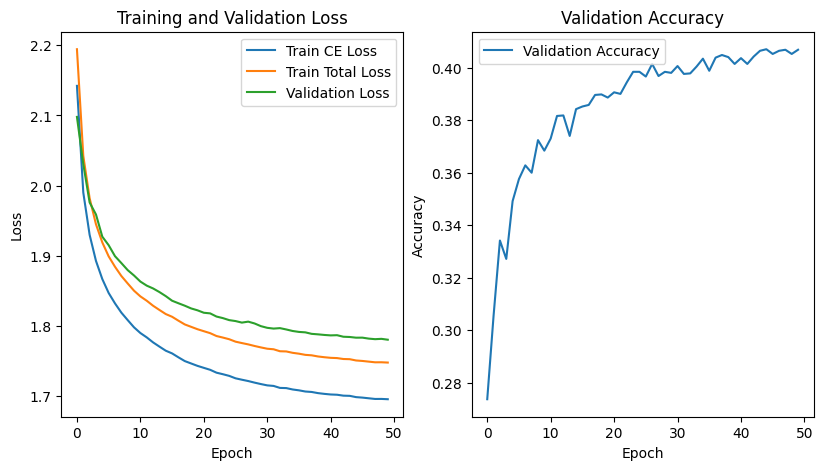

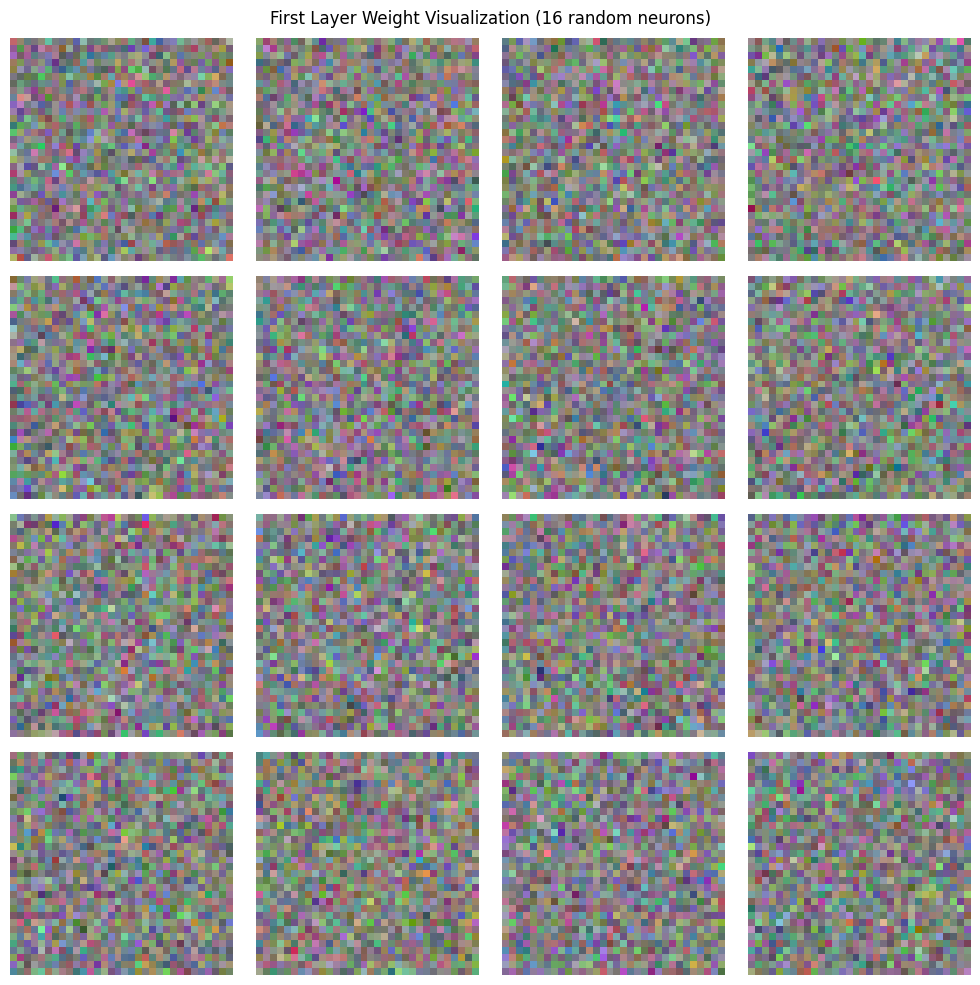

In [76]:
visualize_training(best_history)

In [77]:
def test_model(model, X_test, y_test, batch_size=64, verbose=True):
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test.astype(int)
    
    correct = 0
    total = 0
    predictions = []

    for i in range(0, X_test.shape[0], batch_size):
        X_batch = X_test[i:i+batch_size]
        y_batch = y_test_labels[i:i+batch_size]
        scores = model.forward(X_batch)
        batch_preds = np.argmax(scores, axis=1)
        correct += np.sum(batch_preds == y_batch)
        total += len(y_batch)
        predictions.extend(batch_preds.tolist())
    
    test_acc = correct / total
    
    if verbose:
        print(f"\nTest Accuracy: {test_acc*100:.2f}%")
        print(f"Correct/Total: {correct}/{total}")
    
    return test_acc, np.array(predictions)

In [80]:
test_model(model, x_test, y_test, batch_size=64, verbose=True)


Test Accuracy: 38.64%
Correct/Total: 3864/10000


(0.3864, array([3, 9, 8, ..., 5, 4, 7]))